# SPT local backgrounds SNR plots
Author: Benjamin Floyd

This notebook computes and displays the SNRs between the line-of-sight IR-bright AGN and the local backgrounds for each of the clusters.

In [1]:
import json
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import QTable, join, vstack
from astropy.wcs import WCS

In [2]:
def calculate_area(mask_files: list) -> u.Quantity:
    # Read in each mask file and calculate the allowable area
    areas = []
    for mask_file in mask_files:
        mask_img, mask_hdr = fits.getdata(mask_file, header=True)
        mask_wcs = WCS(mask_hdr)

        # Get the area of a pixel in angular units
        pixel_area = mask_wcs.proj_plane_pixel_area()

        # Find the total area of the image by adding all pixels and multiplying by the pixel area
        mask_area = np.count_nonzero(mask_img) * pixel_area
        areas.append(mask_area)

    # Compute total area in sample
    return u.Quantity(areas).sum()

In [3]:
# Read in the AGN catalog
sptcl_iragn = QTable.read('Data_Repository/Project_Data/SPT-IRAGN/Output/SPTcl_IRAGN_no-stars.fits')

# Also read in the local background surface density file
with open('Data_Repository/Project_Data/SPT-IRAGN/local_backgrounds/SPTcl-local_bkg_frac_err_pivot.json') as f:
    local_bkgs = json.load(f)
# Recast as a table
local_bkgs = QTable(rows=[[cluster_name, surf_den] for cluster_name, surf_den in local_bkgs.items()], names=['SPT_ID', 'local_bkg_surf_den'], units=[None, u.deg**-2])

In [4]:
# Group the catalog by cluster
sptcl_iragn_grp = sptcl_iragn.group_by('SPT_ID')

# Gather cluster information
cluster_info = vstack([QTable(cluster['SPT_ID', 'SZ_RA', 'SZ_DEC', 'REDSHIFT', 'M500'][0]) for cluster in sptcl_iragn_grp.groups])

In [5]:
# Compute the line-of-sight surface densities
los_surf_dens = []
for cluster in sptcl_iragn_grp.groups:
    cluster_id = cluster['SPT_ID'][0]
    mask_name = cluster['MASK_NAME'][0]

    # Compute the number of AGN in the line-of-sight
    los_no_agn = cluster['COMPLETENESS_CORRECTION'].sum()

    # Compute the area of the line-of-sight field
    los_area = calculate_area([mask_name])

    los_surf_den = los_no_agn / los_area
    los_surf_dens.append([cluster_id, los_no_agn, los_area, los_surf_den])
los_surf_dens = QTable(rows=los_surf_dens, names=['SPT_ID', 'los_no_agn', 'los_area', 'los_surf_den'], units=[None, None, u.deg**2, u.deg**-2])

In [6]:
# Merge the two tables
sptcl_surf_dens = join(los_surf_dens, local_bkgs, keys='SPT_ID')

# Add the cluster information
sptcl_surf_dens = join(sptcl_surf_dens, cluster_info, keys='SPT_ID')

# Compute the "cluster" surface densities
sptcl_surf_dens['cluster_surf_den'] = sptcl_surf_dens['los_surf_den'] - sptcl_surf_dens['local_bkg_surf_den']

[Text(0.5, 0, 'Cluster Redshift'),
 Text(0, 0.5, '$\\Sigma_{\\rm AGN, LoS} - \\Sigma_{\\rm AGN, bkg}$ [arcmin$^{-2}$]')]

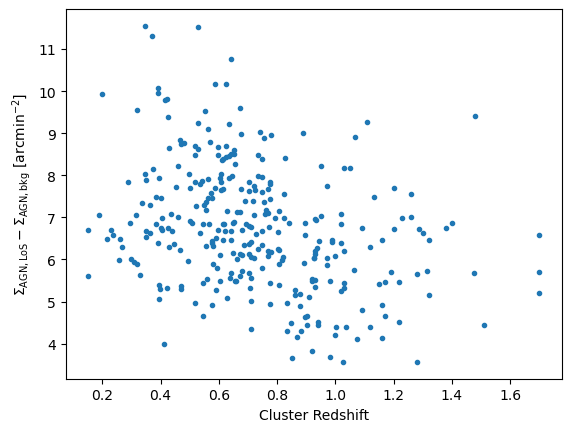

In [7]:
fig, ax = plt.subplots()
cb = ax.scatter(sptcl_surf_dens['REDSHIFT'], sptcl_surf_dens['cluster_surf_den'].to_value(u.arcmin**-2), marker='.')
ax.set(xlabel='Cluster Redshift', ylabel=r'$\Sigma_{\rm AGN, LoS} - \Sigma_{\rm AGN, bkg}$ [arcmin$^{-2}$]')
# fig.savefig('Data_Repository/Project_Data/SPT-IRAGN/cluster-bkg_snr/cluster_agn_surf_den-z.pdf')

[Text(0.5, 0, '$M_{500}$ [$10^{14} M_\\odot$]'),
 Text(0, 0.5, '$\\Sigma_{\\rm AGN, LoS} - \\Sigma_{\\rm AGN, bkg}$ [arcmin$^{-2}$]')]

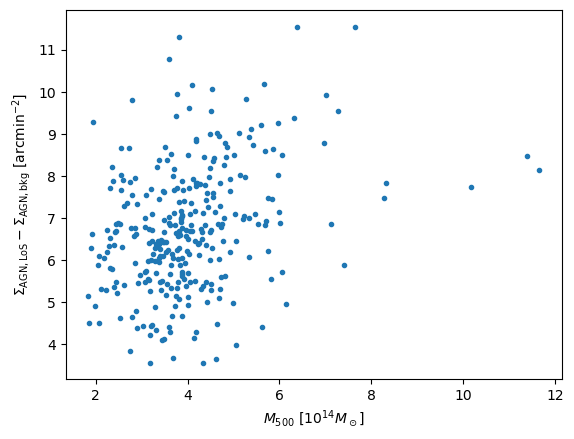

In [8]:
fig, ax = plt.subplots()
cb = ax.scatter(sptcl_surf_dens['M500']/1e14, sptcl_surf_dens['cluster_surf_den'].to_value(u.arcmin**-2), marker='.')
# plt.colorbar(cb, label=r'$M_{500}$ [$10^{14} M_\odot$]')
ax.set(xlabel=r'$M_{500}$ [$10^{14} M_\odot$]', ylabel=r'$\Sigma_{\rm AGN, LoS} - \Sigma_{\rm AGN, bkg}$ [arcmin$^{-2}$]')
# fig.savefig('Data_Repository/Project_Data/SPT-IRAGN/cluster-bkg_snr/cluster_agn_surf_den-m500.pdf')

In [9]:
cluster_excess = sptcl_surf_dens['los_no_agn'] - (sptcl_surf_dens['local_bkg_surf_den'] * sptcl_surf_dens['los_area'])
field_err = np.sqrt(sptcl_surf_dens['local_bkg_surf_den'] * sptcl_surf_dens['los_area'])
sptcl_surf_dens['snr'] = cluster_excess / field_err

In [10]:
sptcl_surf_dens['local_bkg_surf_den']

<Quantity [2194.36205466, 1992.45206917, 2784.6319429 , 3476.00293637,
           3611.608657  , 4403.34522418, 2668.88723247, 2981.03965225,
           1474.26327116, 4228.59452128, 1447.5914338 , 1578.26512221,
           3618.70436947, 3840.98637608, 3217.21063766, 4735.76851982,
           3676.10194982, 1412.67736618, 4315.53692795, 4598.68414456,
           3573.73847146, 1818.31305209, 5207.50032913, 2703.4975216 ,
           2987.52860583, 3968.45534639, 2062.3942076 , 1741.52480761,
           1628.18639781, 3506.07370538, 2520.70193123, 2690.03657839,
           1162.74819922, 1500.6479473 , 3845.48259863, 1609.20960596,
           4787.8389041 , 1385.43845657, 3322.74122487, 3285.00070324,
           4282.34336348, 2860.89761165, 2598.18039046, 1816.79991974,
           1271.81286856, 1345.01696304, 2951.87364956, 1687.39964637,
           2470.41648286, 1129.59709516, 1609.44589145, 2688.66204154,
           2864.00966015, 1358.16193984, 1982.39692726, 1749.19952878,
      

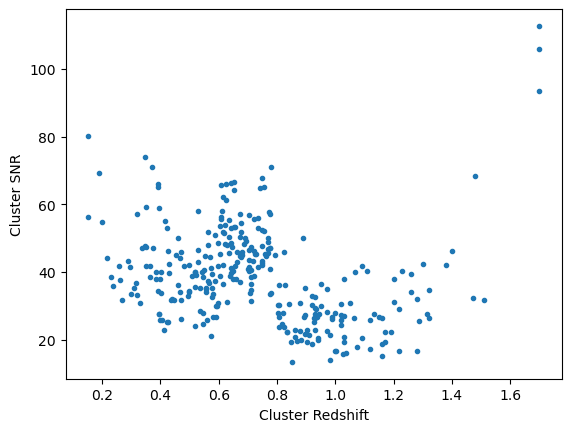

In [12]:
fig, ax = plt.subplots()
ax.scatter(sptcl_surf_dens['REDSHIFT'], sptcl_surf_dens['snr'], marker='.')
ax.set(xlabel='Cluster Redshift', ylabel='Cluster SNR')
fig.savefig('Data_Repository/Project_Data/SPT-IRAGN/cluster-bkg_snr/cluster_agn_snr.pdf')